In [8]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import pickle
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 256
N_EPOCHS = 10

IMG_SIZE = 32
N_CLASSES = 10

In [4]:
transformations = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor(),])

train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transformations,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transformations)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [5]:
## Model from https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        # probs = F.softmax(logits, dim=1)
        # return logits, probs
        return logits

In [6]:
model_path = ''
model = pickle.load(open(model_path, 'rb'))

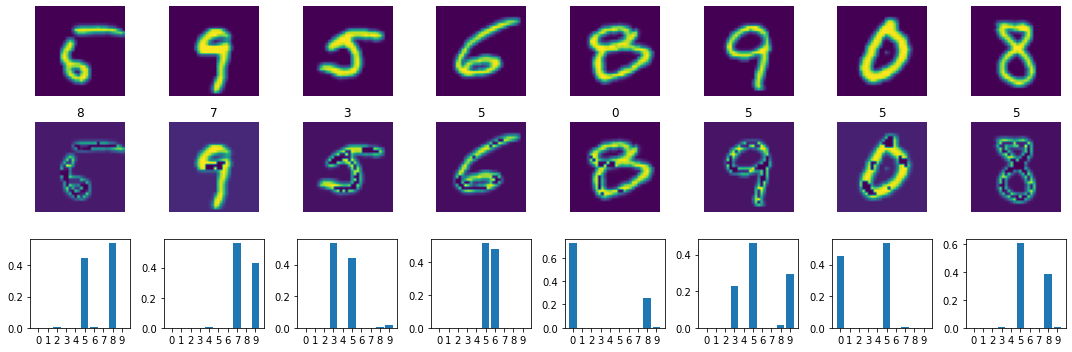

In [14]:
from CW_L0_attack import Carlini0

fig=plt.figure(figsize=(15,5))

def inference(model, dataset_sample, i, n_samples):
    
    sample = dataset_sample[0]
    y = torch.tensor(dataset_sample[1], device=device).unsqueeze(0)
    x = sample.unsqueeze(0)
    x = x.to(device)

    sub = fig.add_subplot(3, n_samples, i+1)
    plt.axis('off')
    plt.imshow(x[0][0].detach().cpu().numpy())
    
    atk = CarliniL0(model, num_labels = 10, image_size=32, num_channels=1, batch_size=1, max_iterations=10, initial_const=1, largest_const=15)
    x_adv = atk.attack(x, y)
    
    y_hat = model(x_adv)
    y_prob = F.softmax(y_hat, dim=1)
    _, predicted_labels = torch.max(y_prob, 1)

    sub = fig.add_subplot(3, n_samples, n_samples+i+1)
    plt.axis('off')
    sub.set_title(predicted_labels.item())
    plt.imshow(x_adv[0][0].detach().cpu().numpy())
    plt.tight_layout()

    sub = fig.add_subplot(3, n_samples, 2*n_samples+i+1)
    plt.xticks(range(10))
    plt.bar(range(10), y_prob[0].tolist())

n_samples = 8
indices = random.sample(range(0, len(valid_dataset)), n_samples)
for i, index in enumerate(indices):
    inference(model, valid_dataset[index], i, n_samples)